In [1]:
from utils.Auger.SD.Monitoring import Monit
from scipy.optimize import curve_fit
from utils.binaries import *
from utils.plotting import *
from utils import CONSTANTS
import os

def parabola(x, scale, mip, y0):
    return scale * (x-mip)**2 + y0

def make_histo_fit(counts, p, t=None, version=None):
     
    # see Framework/SDetector/Station.h
    match p:
        case 0 | 1 | 2:
            ADC_bin_edges = np.array([4*k for k in range(100)] + [400 + 16*k for k in range(51)])
        case 3:
            ADC_bin_edges = np.array([2*k for k in range(100)] + [200 + 8*k for k in range(51)])
    ADC = 0.5 * (ADC_bin_edges[1:] + ADC_bin_edges[:-1])

    skip = 5
    _peak = np.argmax(counts[skip:100]) + skip
    _dip = np.argmax(np.diff(counts)) + 3
    start, stop = _dip + int(0.5 * (_peak - _dip)), _peak + int(0.5*(_peak - _dip))

    try:
        (curve, mip, height), pcov = curve_fit(parabola, ADC[start:stop], counts[start:stop],
                                        bounds=([-np.inf, 0, 0],[0, np.inf, np.inf]),
                                        maxfev=10000,
                                        p0=[-1, ADC[_peak], counts[_peak]])

        file_loc = f"/cr/data01/filip/plots/DaqIntegrationTest/{version}/pmt{int(p)}/{t}.png"

        if not os.path.isfile(file_loc):
            os.makedirs(f"/cr/data01/filip/plots/DaqIntegrationTest/{version}/pmt{int(p)}/", exist_ok=True)
            fig = plt.figure()
            plt.plot(ADC, counts)
            plt.plot(ADC[start:stop], parabola(ADC[start:stop], curve, mip, height))
            plot.save(fig, f'DaqIntegrationTest/{version}/pmt{int(p)}/{t}.png')
            plt.close(fig)


        (_, mip, _) = uncertainties.correlated_values([curve, mip, height], pcov)
        if mip.std_dev / mip.n > 0.1: raise ValueError
        if mip.n > 300: raise ValueError
    except:
        return np.nan, np.nan

    return mip.n, mip.std_dev

13:23:34 (   +1.4s) [INFO   ] -- import logging
13:23:34 (    +2ms) [INFO   ] -- import numpy as np
13:23:34 (    +7ms) [INFO   ] -- import uncertainties
13:23:34 (    +2ms) [INFO   ] -- import numpy as np
13:23:34 (    +7ms) [INFO   ] -- import uncertainties
13:23:35 (  +343ms) [INFO   ] -- import pandas as pd
13:23:35 (    +1ms) [WARNING] -- pandas support to be dropped at some point!
13:23:35 (    +2ms) [INFO   ] -- import binaries.tools as tools
13:23:35 (  +622ms) [INFO   ] -- import matplotlib.pyplot as plt
13:23:35 (  +275ms) [INFO   ] -- import seaborn as so
13:23:35 (    +1ms) [INFO   ] -- import plotting.tools as plot
13:23:35 (   +10ms) [DEBUG  ] -- font size set to 9.5
13:23:35 (    +0ms) [DEBUG  ] -- label size set to 13.0
13:23:35 (    +1ms) [DEBUG  ] -- figure size set to [6.6, 3.3]
13:23:35 (    +1ms) [DEBUG  ] -- markersize set to 2.0
13:23:35 (    +0ms) [DEBUG  ] -- usetex set to False


13:23:35 (   +19ms) [INFO   ] -- received 2 file(s) as input
13:23:36 (  +194ms) [INFO   ] -- View monit keys with self.keys()
13:23:36 (  +119ms) [INFO   ] -- found 775 entries for key fTime and station #136
13:23:36 (   +16ms) [INFO   ] -- found 775 entries for key fPeak and station #136
/tmp/ipykernel_2911320/3507692559.py:27: OptimizeWarning: Covariance of the parameters could not be estimated
  (curve, mip, height), pcov = curve_fit(parabola, ADC[start:stop], counts[start:stop],
/cr/users/filip/.venv/lib/python3.10/site-packages/uncertainties/core.py:188: RuntimeWarning: invalid value encountered in divide
  covariance_mat/norm_vector/norm_vector[:,numpy.newaxis],
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


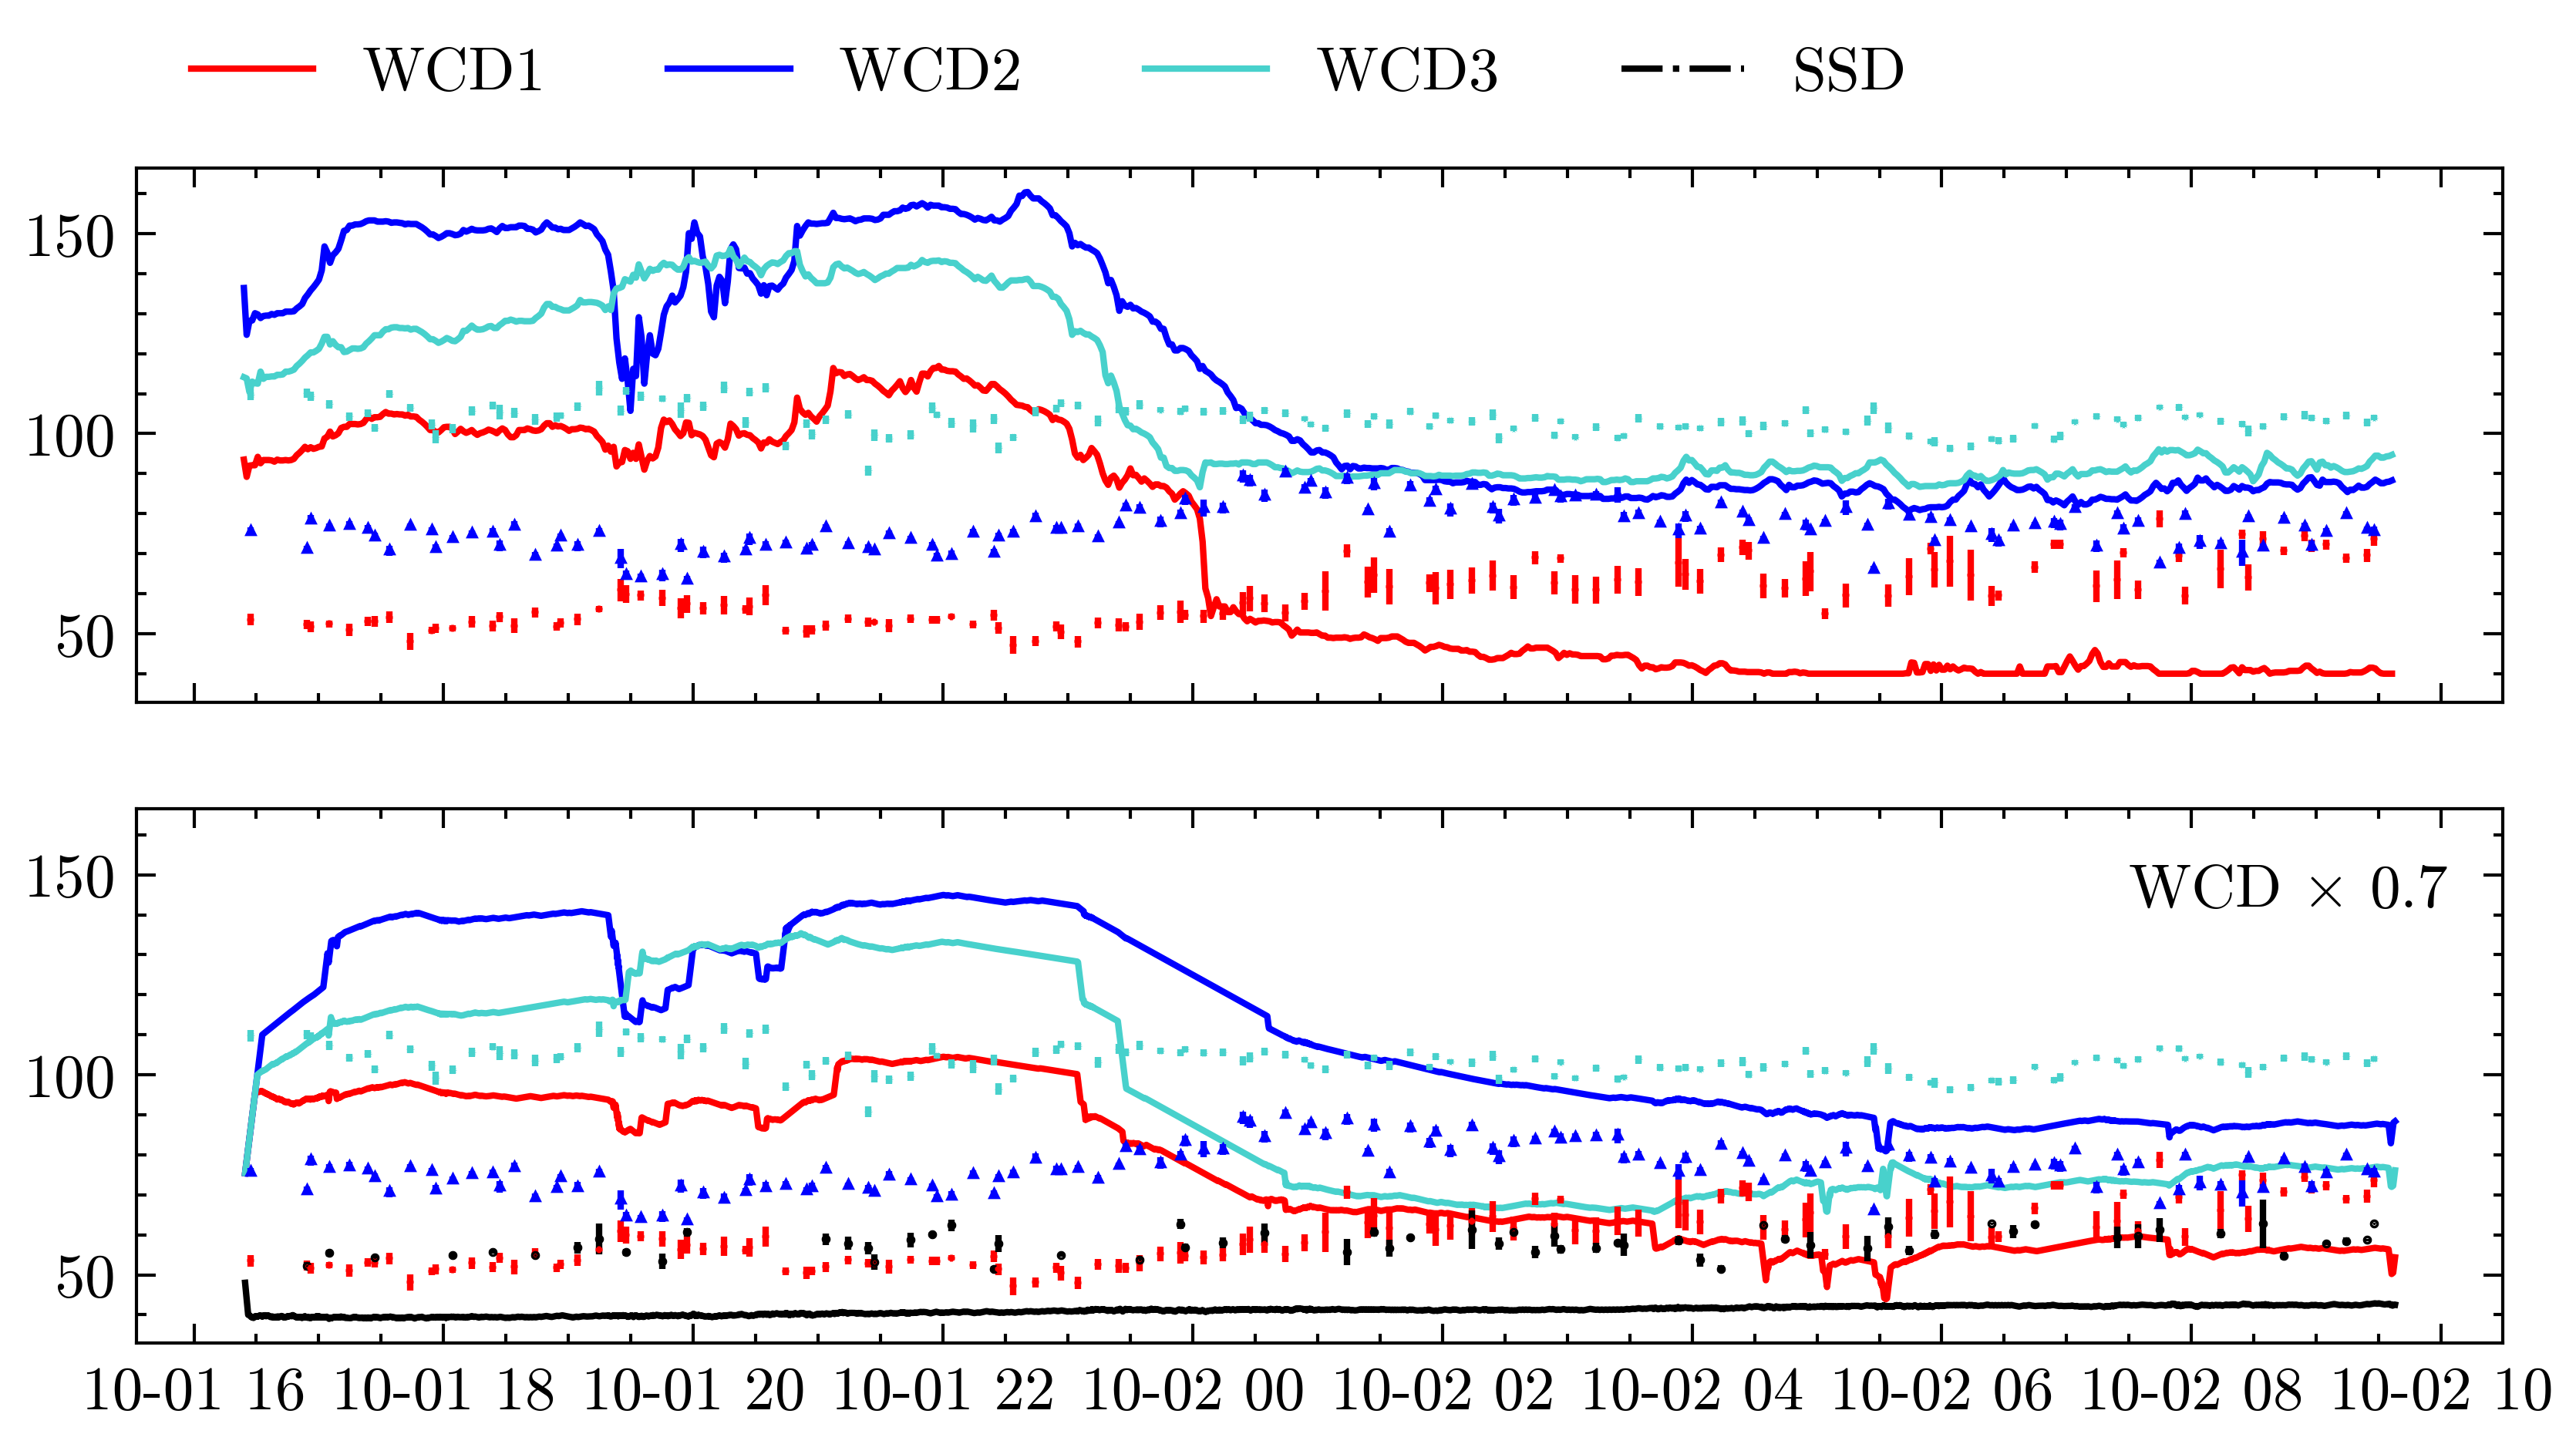

In [2]:

errorbar_kwargs = [
    {'marker' : 'x', 'c' : 'r'},
    {'marker' : '^', 'c' : 'b'},
    {'marker' : '*', 'c' : 'mediumturquoise'},
    {'marker' : 'o', 'c' : 'k'},
]

version = 'v30'
base = f'/cr/data01/filip/Data/daqIntegrationTests/{version}/'
monit_files = [base + file for file in os.listdir(base) if 'mc' in file]

monit = Monit(*monit_files)
t, (wcd1, wcd2, wcd3) = monit('fTime', 136), monit('fPeak', 136).T
mask = [True if v != 0 else False for v in wcd3]

_, t_acq, t_gps, pmt, *histos = np.loadtxt(f'/cr/data01/filip/Data/daqIntegrationTests/{version}/out.txt', unpack=True)
histo_mask = np.where(np.sum(np.array(histos).T[:, :25], axis=1))[0]

t_muonbuffer, mf_wcd1, hz1, mf_wcd2, hz2, mf_wcd3, hz3, ssd, hz4 = np.loadtxt(f'/cr/data01/filip/Data/daqIntegrationTests/{version}/calib.test', unpack=True)
t_muonbuffer += CONSTANTS.GPS_OFFSET

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True)

ax1.plot(plot.to_datetime(t[mask]), wcd1[mask], c='r', label='WCD1', ls='solid')
ax1.plot(plot.to_datetime(t[mask]), wcd2[mask], c='b', label='WCD2', ls='solid')
ax1.plot(plot.to_datetime(t[mask]), wcd3[mask], c='mediumturquoise', label='WCD3', ls='solid')
ax1.plot([],[],c='k', ls='-.', label='SSD')

ax2.plot(plot.to_datetime(t_muonbuffer), mf_wcd1 / 1.3, c='r', ls='solid')
ax2.plot(plot.to_datetime(t_muonbuffer), mf_wcd2 / 1.3, c='blue', ls='solid')
ax2.plot(plot.to_datetime(t_muonbuffer), mf_wcd3 / 1.3, c='mediumturquoise', ls='solid')
ax2.plot(plot.to_datetime(t_muonbuffer), ssd, c='k')

for i, (tx, p, histo) in enumerate(zip(t_gps[histo_mask], pmt[histo_mask], np.array(histos).T[histo_mask])):

    mip, std_mip = make_histo_fit(histo, p, tx, version)
    if p != 3: ax1.errorbar(plot.to_datetime(tx), mip, std_mip, ms=0.4, **errorbar_kwargs[int(p)])
    ax2.errorbar(plot.to_datetime(tx), mip, std_mip, ms=0.4, **errorbar_kwargs[int(p)])


left, right = ax1.get_xlim()
bottom, top = ax1.get_ylim()

# ax1.fill_between(plot.to_datetime(t), bottom, top, 
#                  where=[a < t_muonbuffer[0] or a > t_muonbuffer[-1] for a in t], 
#                  color='gray', alpha=0.1, label='V128r0b0p29')

ax1.set_xlim(left, right)
ax1.set_ylim(bottom, top)

ax1.legend(bbox_to_anchor=(0, 1.02,1,0.2), loc="lower left", ncol=4)
ax2.legend(title=r'WCD $\times$ 0.7')
# ax1.legend(title='Xb')
# ax2.legend(title='MuonFill')